# Equity versus fixed income: the predictive power of bank surveys

This notebook serves as an illustration of the points discussed in the post ["Equity versus fixed income: the predictive power of bank surveys"](https://research.macrosynergy.com/equity-versus-fixed-income-the-predictive-power-of-bank-surveys/) available on the Macrosynergy website. 

Bank lending surveys help predict the relative performance of equity and duration positions. Signals of strengthening credit demand and easing lending conditions favor a stronger economy and expanding leverage, supporting equity returns. Signs of deteriorating credit demand and tightening credit supply bode for a weaker economy and more accommodative monetary policy, supporting duration returns. Empirical evidence for developed markets strongly supports these propositions. Since 2000, bank survey scores have been a significant predictor of equity versus duration returns. They helped create uncorrelated returns in both asset classes, as well as for a relative asset class book.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs various calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including constructing weighted average credit demand, average developed markets equity and duration returns, and relative equity vs. duration returns.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. Depending on the analysis, this section involves backtesting various trading strategies targeting equity, fixed income and relative returns. The strategies utilize the inflation indicators and other signals derived in the previous section.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users. Users can modify the code to test different hypotheses and strategies based on own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Uncomment below if the latest macrosynergy package is not installed
"""
%%capture
! pip install macrosynergy --upgrade"""

'\n%%capture\n! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
from macrosynergy.download import JPMaQSDownload

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).

In [3]:
# Cross-sections of interest

cids_dm = ["EUR", "GBP", "JPY", "CAD", "USD"]
cids = cids_dm

In [4]:
# Quantamental categories of interest
main = ["BLSDSCORE_NSA", # Demand
        "BLSCSCORE_NSA"]  # Suppl

econ = ["USDGDPWGT_SA_3YMA"]  # economic context

mark = [
    "DU05YXR_VT10",
    "EQXR_VT10",
]  # market context

xcats = main + econ + mark

# Extra tickers

xtix = ["USD_GB10YXR_NSA"]

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + xtix
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 26


JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Bank survey scores](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Bank%20survey%20scores.php?highlight=blsdscore),  [Global production shares](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php?highlight=usdgdpwgt), [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php), and [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php).

In [5]:
start_date = "2000-01-01"
# end_date = "2023-05-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        # end_date=end_date,
        suppress_warning=True,
        metrics=["all"],
        report_time_taken=True,
        show_progress=True,
    )

Timestamp UTC:  2024-03-27 12:00:32
Connection successful!


Requesting data: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Time taken to download data: 	9.64 seconds.
Some expressions are missing from the downloaded data. Check logger output for complete list.
4 out of 104 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
3 out of 6325 dates are missing.


In [6]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149686 entries, 8602 to 149685
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  149686 non-null  datetime64[ns]
 1   cid        149686 non-null  object        
 2   xcat       149686 non-null  object        
 3   eop_lag    149686 non-null  float64       
 4   grading    149686 non-null  float64       
 5   mop_lag    149686 non-null  float64       
 6   value      149686 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 9.1+ MB


## Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

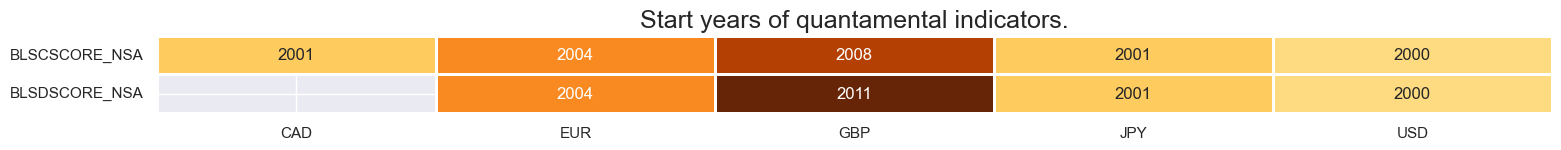

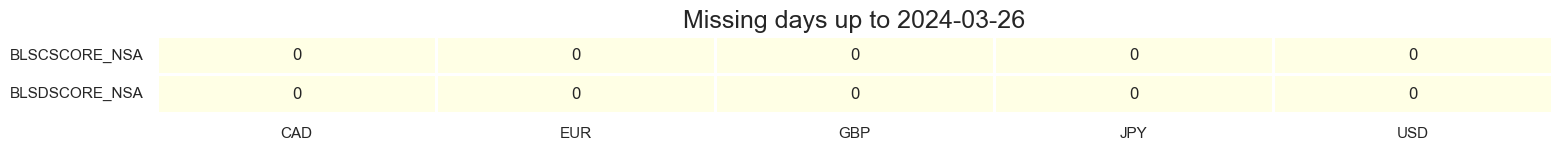

In [7]:
msm.check_availability(df, xcats=main, cids=cids, missing_recent=True)

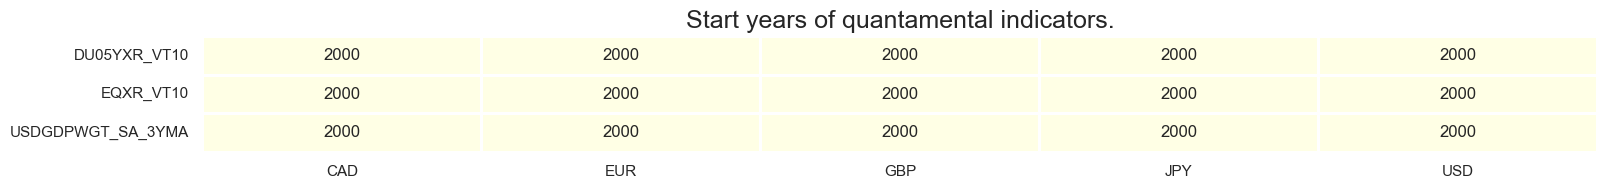

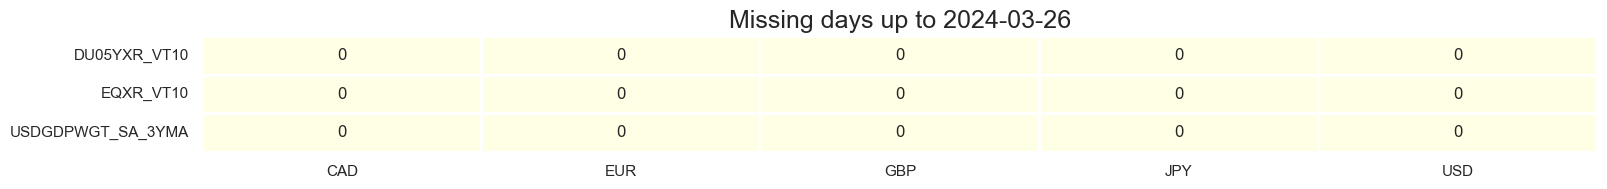

In [8]:
msm.check_availability(df, xcats=econ + mark, cids=cids, missing_recent=True)

# Transformations and checks

In this section, we conduct straightforward calculations and transformations on the data to derive the essential signals and targets necessary for the analysis.

## Features

The presented chart illustrates the weighted average of credit demand and supply conditions in developed markets, derived from bank lending surveys. Specifically, it incorporates the credit demand z-score (`BLSDSCORE_NSA`) and credit supply z-score (`BLSCSCORE_NSA`) for developed countries, namely EUR, GBP, JPY, CAD, and USD. Weights are assigned based on the respective proportions of global GDP and industrial production, calculated as a three-year moving average. Subsequently, both the aggregated credit demand z-score and credit supply z-score are grouped under the identifier GDM.

To visualize these combined indicators, we utilize the `view_timelines()` function from the macrosynergy package. You can find more information about this function [here](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines)

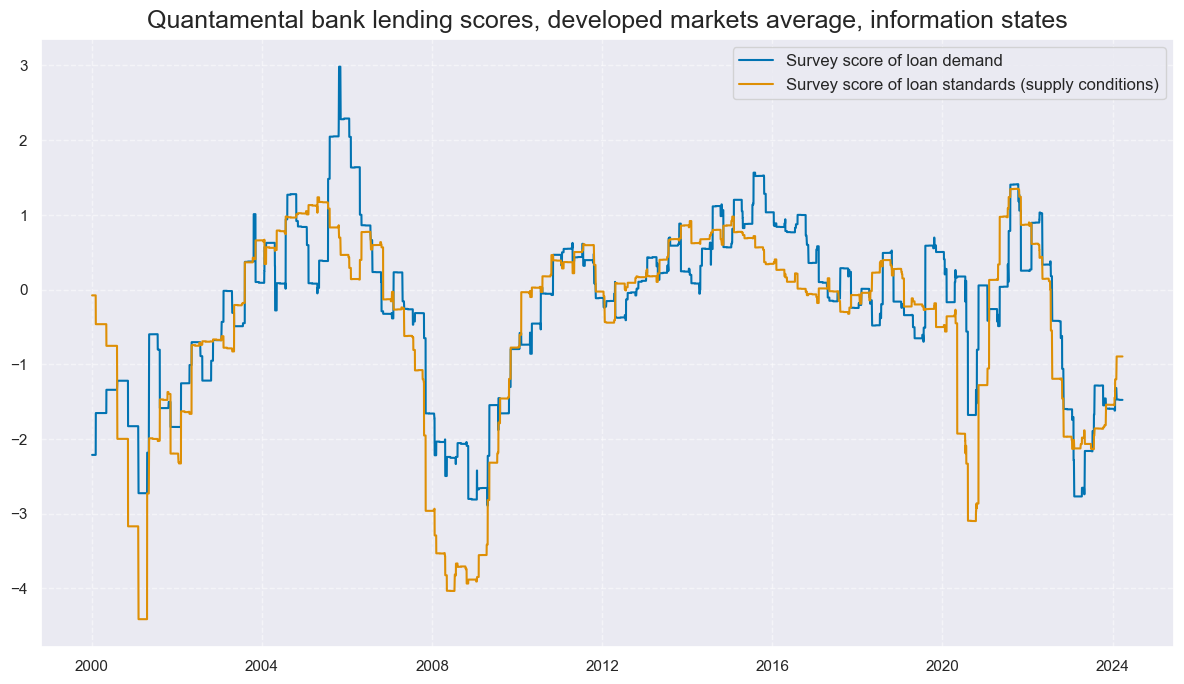

In [9]:
cidx = cids_dm
xcatx = ["BLSDSCORE_NSA", "BLSCSCORE_NSA"]

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xc,
        cids=cidx,
        weights="USDGDPWGT_SA_3YMA",
        new_cid="GDM",
        complete_cids=False,
        complete_xcats=False,
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

cidx = ["GDM"]
sdate = "2000-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=False,
    start=sdate,
    title="Quantamental bank lending scores, developed markets average, information states",
    title_fontsize=18,
    xcat_labels=[
        "Survey score of loan demand",
        "Survey score of loan standards (supply conditions)",
    ],
    )

## Targets

### Equity and duration returns

In this segment, we amalgamate the volatility-targeted returns of both equity and fixed income from developed countries into a composite basket, where each country contributes equally. The initial list of countries, downloaded and compiled in the `cids_dm` list, encompasses EUR, GBP, JPY, CAD, and USD. The resulting new time series will be labeled as GDM (Global developed markets) and will be based on the respective averages of two crucial indicators:

- Volatility-targeted equity returns, `EQXR_VT10` These returns signify the near-future performance of major equity indices, including the Standard and Poor’s 500 Composite in USD, EURO STOXX 50 in EUR, Nikkei 225 Stock Average in JPY, FTSE 100 in GBP, and the Toronto Stock Exchange 60 Index in CAD.

- Volatility-targeted duration returns, `DU05YXR_VT10`. These returns reflect the performance of 5-year interest rate swap fixed receiver positions, assuming a monthly roll.

Alternatively,  one can consider using just 3 main currencies USD, EUR, and JPY. The new series will get the cross-sectional label `G3`.

To visualize these combined indicators, we utilize the `view_timelines()` function from the macrosynergy package. You can find more information about this function [here]((https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines))

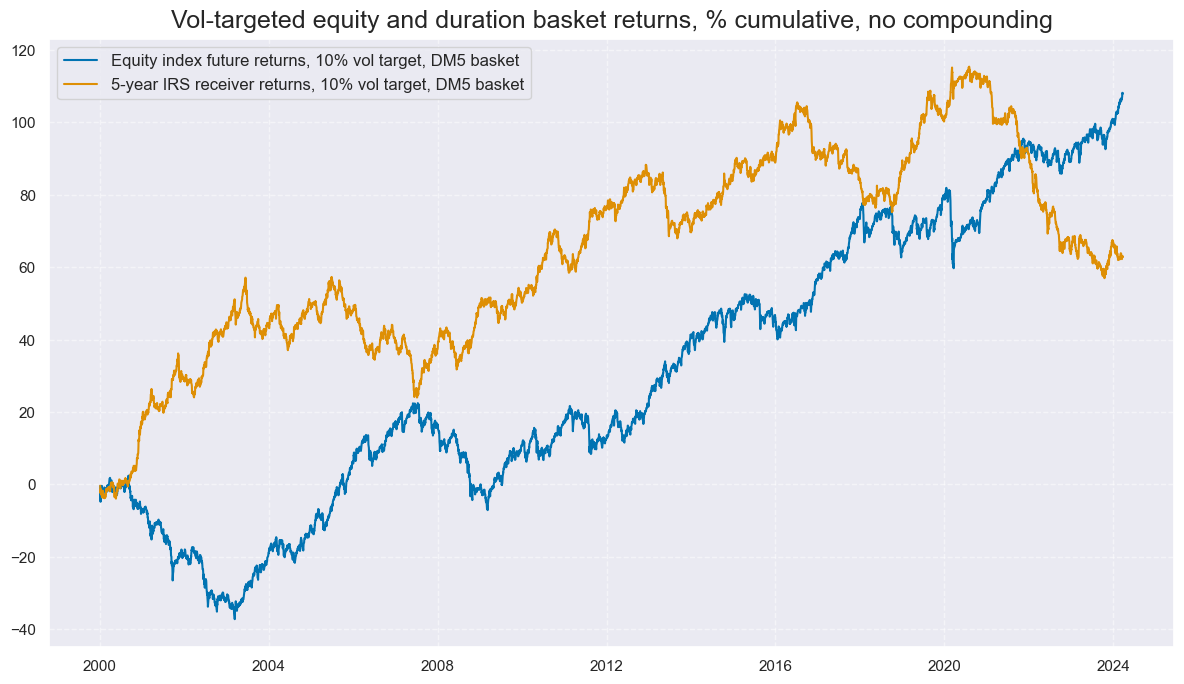

In [10]:
xcatx = ["EQXR_VT10", "DU05YXR_VT10"]
dict_bsks = {
    "GDM": cids_dm,
    "G3": ["EUR", "JPY", "USD"],
}

dfa = pd.DataFrame(columns=list(dfx.columns))
for xc in xcatx:
    for key, value in dict_bsks.items():
        dfaa = msp.linear_composite(
            df=dfx,
            xcats=xc,
            cids=value,
            new_cid=key,
            complete_cids=False,
        )
        dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

cidx = ["GDM"]
sdate = "2000-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    cumsum=True,
    start=sdate,
    same_y=False,
    title="Vol-targeted equity and duration basket returns, % cumulative, no compounding",
    title_fontsize=18,
    xcat_labels=[
        "Equity index future returns, 10% vol target, DM5 basket",
        "5-year IRS receiver returns, 10% vol target, DM5 basket",
        
    ],
   )

### Equity versus duration returns

In this notebook we look at the directional and at the relative returns for developed markets. We establish a fresh metric `EQvDUXR_VT10`, defined as the difference between `EQXR_VT10` and `DU05YXR_VT10`. Subsequently, we consolidate individual country indicators into a unified metric, employing equal weighting for each cross-section. Similar to our previous approach, this newly combined metric, `EQvDUXR_VT10`, is classified under the cross-sectional identifier `GDM`.

In [11]:
cidx = cids_dm
calcs = [
    "EQvDUXR_VT10 = EQXR_VT10 - DU05YXR_VT10",
]

dfa = msp.panel_calculator(df, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

xcatx = ["EQvDUXR_VT10"]
dict_bsks = {
    "GDM": cids_dm,
    "G3": ["EUR", "JPY", "USD"],
}

dfa = pd.DataFrame(columns=list(dfx.columns))
for xc in xcatx:
    for key, value in dict_bsks.items():
        dfaa = msp.linear_composite(
            df=dfx,
            xcats=xc,
            cids=value,
            new_cid=key,
            complete_cids=False,
        )
        dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

# Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for directional equity, fixed income, and relative strategies using bank lending scores. The PnLs are calculated based on simple trading strategies that utilize the bank lending scores as signals (no regression analysis is involved). The strategies involve going long (buying) or short (selling) on respective asset positions based purely on the direction of the signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the inflation-based strategy returns and the actual returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of inflation-based strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision, etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these simple inflation-based strategies with the long-only performance of the respective asset classes. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

The analysis in the post and sample code in the notebook is a proof of concept only, using the simplest design.

## Duration returns

In this section, we test a simple idea that bank survey scores negatively predict fixed receiver returns in the interest rate swap market. 

### Specs and panel test

In [12]:
bls = ["BLSDSCORE_NSA",
    "BLSCSCORE_NSA"]
sigs=bls

targ = "DU05YXR_VT10" 
cidx = ["GDM"]

dict_dubk = {
    "df": dfx,
    "sigs": sigs,
    "targ": targ,
    "cidx": cidx,
    "black": None,
    "srr": None,
    "pnls": None,
}

We utilize the `CategoryRelations()` function from the `macrosynergy` package to visualize the connection between the bank survey credit demand score `BLSDSCORE_NSA` and the subsequent IRS (Interest Rate Swap) return. As anticipated, the visualization confirms a negative and statistically significant relationship at a 5% significance level. This finding aligns with the expected relationship between credit demand scores and IRS returns. You can access more details on this analysis by referring to the provided [link](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php)

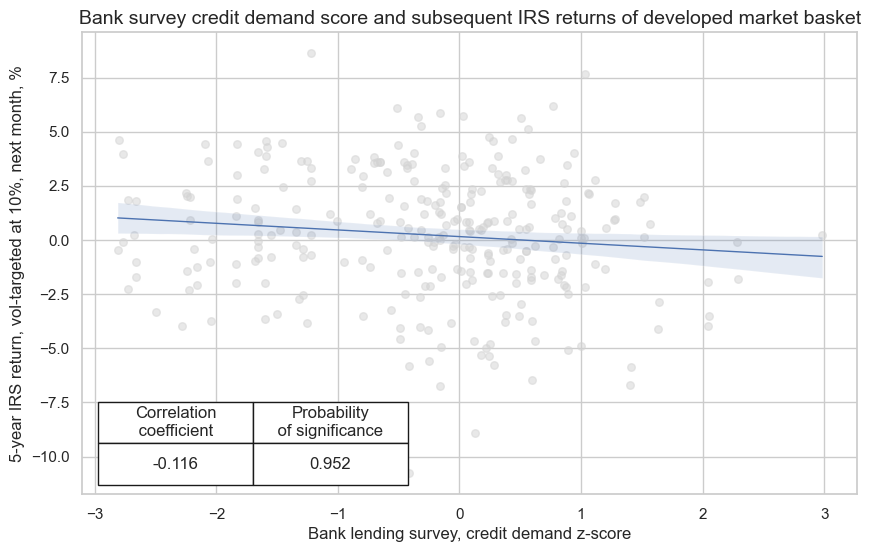

In [13]:

dix = dict_dubk

dfr = dix["df"]
sig = dix["sigs"][0]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit demand z-score",
    ylab="5-year IRS return, vol-targeted at 10%, next month, %",
    title="Bank survey credit demand score and subsequent IRS returns of developed market basket",
    size=(10, 6),
)

Conducting a parallel analysis by employing the alternate bank survey metric, the credit supply score labeled as `BLSCSCORE_NSA`, and subsequently examining the IRS (Interest Rate Swap) returns reveals a notably weaker and less statistically significant relationship. The underlying reasons for this diminished correlation are elaborated upon in the accompanying post. 

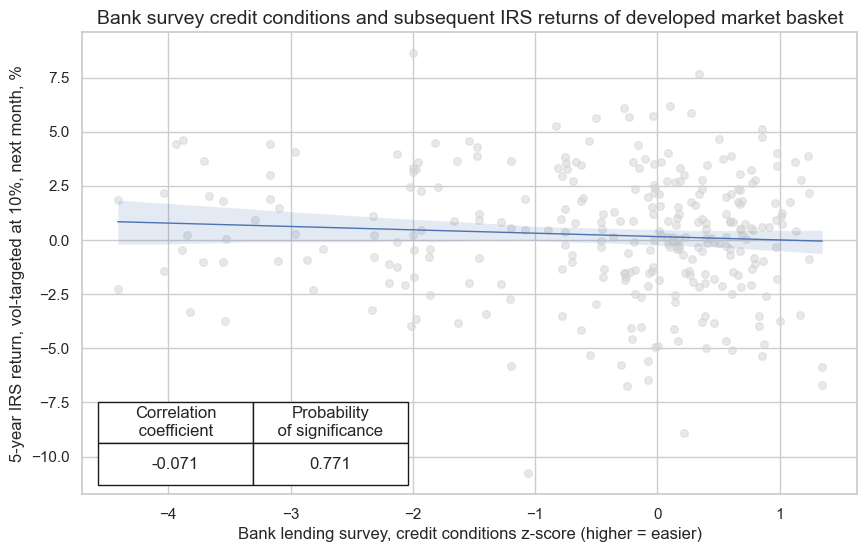

In [14]:
dix = dict_dubk

dfr = dix["df"]
sig = dix["sigs"][1]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit conditions z-score (higher = easier)",
    ylab="5-year IRS return, vol-targeted at 10%, next month, %",
    title="Bank survey credit conditions and subsequent IRS returns of developed market basket",
    size=(10, 6),
)

### Accuracy and correlation check

The [`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [15]:
bls = ["BLSDSCORE_NSA",
    "BLSCSCORE_NSA"]
sigs=bls
targ = "DU05YXR_VT10" 
cidx = ["GDM"]


srr = mss.SignalReturnRelations(
    dfr,
    cids=cidx,
    sigs=sigs,
    sig_neg=[True, True],
    rets=targ,
    freqs="M",
    start="1995-01-01",
)



[`multiple_relations_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) is a method that compares multiple signal-return relations in one table. It is useful to compare the performance of different signals against the same return series (more than one possible financial return) and multiple possible frequencies. 

In [16]:
dix["srr"] = srr
srrx = dix["srr"]
srrx.multiple_relations_table()

accuracy  bal_accuracy  \
Return       Signal            Frequency Aggregation                           
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.493103      0.490948   
             BLSDSCORE_NSA_NEG M         last         0.531034      0.529286   

                                                      pos_sigr  pos_retr  \
Return       Signal            Frequency Aggregation                       
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.520690  0.551724   
             BLSDSCORE_NSA_NEG M         last         0.517241  0.551724   

                                                      pos_prec  neg_prec  \
Return       Signal            Frequency Aggregation                       
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.543046  0.438849   
             BLSDSCORE_NSA_NEG M         last         0.580000  0.478571   

                                                       pearson  pearson_pval  \
Return       Signal            Frequency Aggregation                           
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.070829      0.229177   
             BLSDSCORE_NSA_NEG M         last         0.116411      0.047638   

                                                       kendall  kendall_pval  \
Return       Signal            Frequency Aggregation                           
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.034178      0.385575   
             BLSDSCORE_NSA_NEG M         last         0.082055      0.037239   

                                                           auc  
Return       Signal            Frequency Aggregation            
DU05YXR_VT10 BLSCSCORE_NSA_NEG M         last         0.490865  
             BLSDSCORE_NSA_NEG M         last         0.529567

### Naive PnL

The [`NaivePnl()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) class is specifically designed to offer a quick and straightforward overview of a simplified Profit and Loss (PnL) profile associated with a set of trading signals. The term "naive" is used because the methods within this class do not factor in transaction costs or position limitations, which may include considerations related to risk management. This omission is intentional because the impact of costs and limitations varies widely depending on factors such as trading size, institutional rules, and regulatory requirements.

As its primary objective, the class focuses on tracking the average IRS (Interest Rate Swap) return for developed markets, specifically the 'DU05YXR_VT10,' alongside the trading signals BLSDSCORE_NSA (credit demand z-score) and BLSCSCORE_NSA (credit supply z-score). It accommodates both binary PnL calculations, where signals are simplified into long (1) or short (-1) positions, and proportionate PnL calculations.

For more in-depth information regarding the `NaivePnl() class and its functionalities, you can refer to the provided link [here](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl)

In [17]:
dix = dict_dubk
sigx = dix["sigs"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
  
)

dict_pnls = {
    "PZN0": {"sig_add": 0, "sig_op": "zn_score_pan"},
    "PZN1": {"sig_add": 1, "sig_op": "zn_score_pan"},
    "BIN0": {"sig_add": 0, "sig_op": "binary"},
    "BIN1": {"sig_add": 1, "sig_op": "binary"},
}

for key, value in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_add=value["sig_add"],
            sig_op=value["sig_op"],
            thresh=3,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_" + key,
        )


naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the NaivePnl() class is used to plot a line chart of cumulative PnL

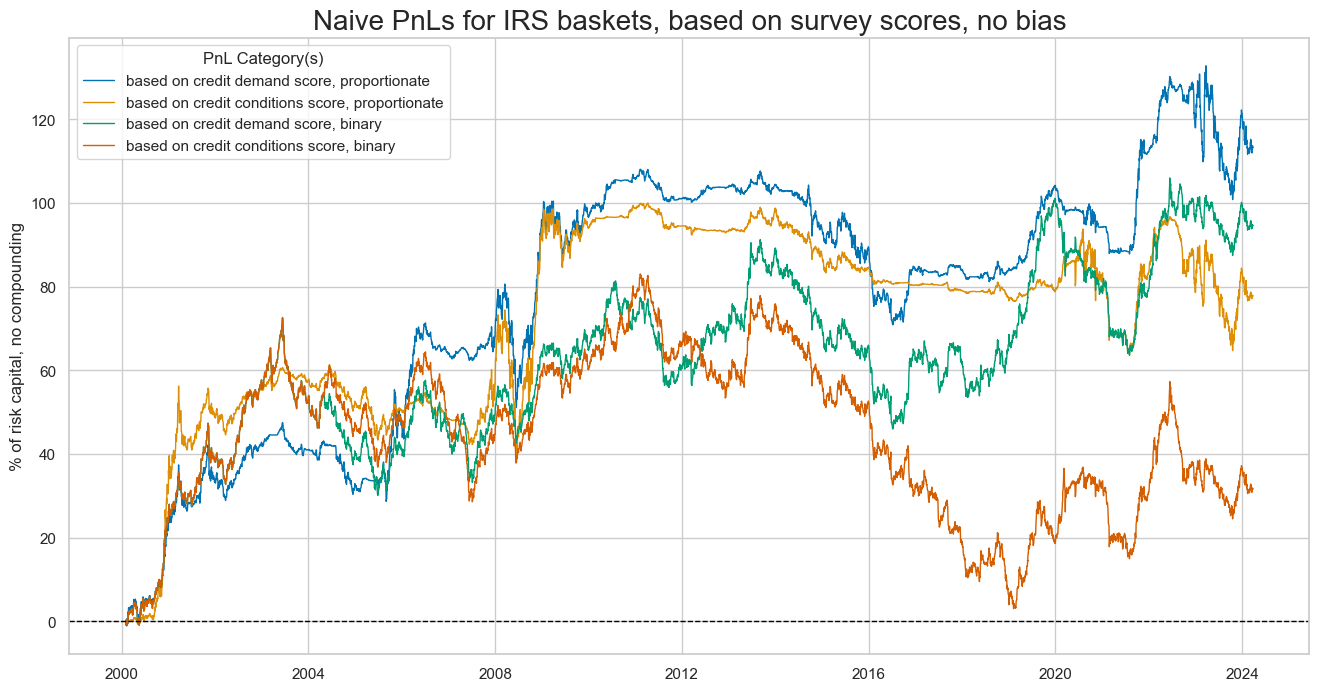

In [18]:
dix = dict_dubk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for type in ["_PZN0", "_BIN0"] for sig in sigx]

dict_labels = {"BLSDSCORE_NSA_PZN0": "based on credit demand score, proportionate", 
               "BLSCSCORE_NSA_PZN0": "based on credit conditions score, proportionate",
               "BLSDSCORE_NSA_BIN0": "based on credit demand score, binary", 
               "BLSCSCORE_NSA_BIN0": "based on credit conditions score, binary"
               }


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    title="Naive PnLs for IRS baskets, based on survey scores, no bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The method [evaluate_pnls()](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) returns a small dataframe of key PnL statistics.

In [19]:
dix = dict_dubk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for sig in sigx for type in ["_PZN0", "_PZN1", "_BIN0", "_BIN1"]] + [
    "Long only"
]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)


In [20]:
display(df_eval.transpose())

,Return (pct ar),St. Dev. (pct ar),Sharpe Ratio,Sortino Ratio,Max 21-day draw,Max 6-month draw,Traded Months
xcat,,,,,,,
BLSCSCORE_NSA_BIN0,1.311453,10.0,0.131145,0.185839,-13.753375,-20.428536,291
BLSCSCORE_NSA_BIN1,3.182654,10.0,0.318265,0.451375,-19.00006,-26.974585,291
BLSCSCORE_NSA_PZN0,3.222786,10.0,0.322279,0.464922,-20.527223,-24.987429,291
BLSCSCORE_NSA_PZN1,4.116934,10.0,0.411693,0.592551,-18.803465,-24.342558,291
BLSDSCORE_NSA_BIN0,3.920496,10.0,0.39205,0.56325,-12.526584,-20.433878,291
BLSDSCORE_NSA_BIN1,5.021935,10.0,0.502193,0.721779,-18.183052,-24.693086,291
BLSDSCORE_NSA_PZN0,4.69431,10.0,0.469431,0.691568,-19.465818,-26.96425,291
BLSDSCORE_NSA_PZN1,5.617326,10.0,0.561733,0.814085,-15.901654,-22.449896,291
Long only,3.125464,10.0,0.312546,0.441982,-13.742726,-28.386188,291


## Equity returns

Similar to the previous chapter, we proceed to explore the connections between bank lending survey scores and consequent equity returns, specifically those targeted at 10% volatility. We initiate this analysis with the bank survey demand score and its correlation with consequent monthly equity index future returns. Evidently, the relationship between these variables exhibits a positive and statistically significant relationship. 

### Specs and panel test

In [21]:
bls = ["BLSDSCORE_NSA",
     "BLSCSCORE_NSA"]
sigs = bls
targ = "EQXR_VT10"
cidx = ["GDM"]

dict_eqbk = {
    "df": dfx,
    "sigs": sigs,
    "targ": targ,
    "cidx": cidx,
    "black": None,
    "srr": None,
    "pnls": None,
}

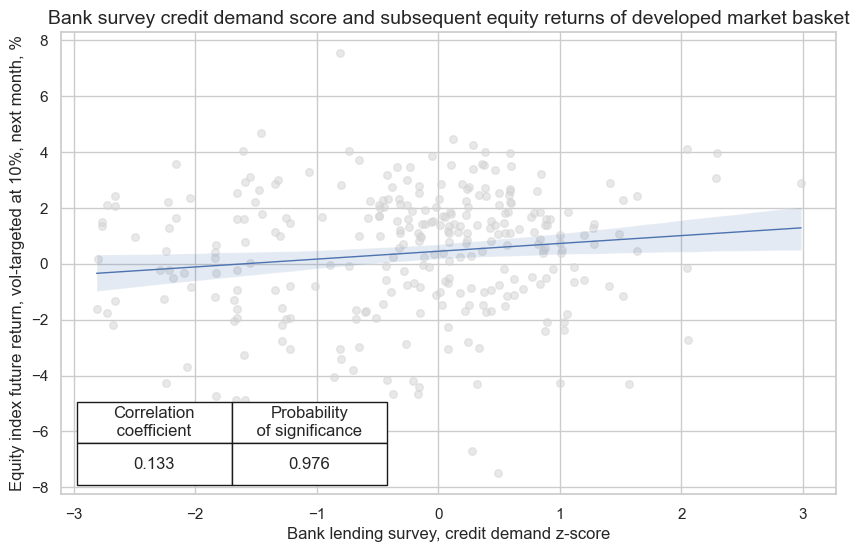

In [22]:
dix = dict_eqbk

dfr = dix["df"]
sig = dix["sigs"][0]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit demand z-score",
    ylab="Equity index future return, vol-targeted at 10%, next month, %",
    title="Bank survey credit demand score and subsequent equity returns of developed market basket",
    size=(10, 6),
)

Predictive correlation has been even a bit stronger between bank lending conditions `BLSCSCORE_NSA` and subsequent monthly equity index returns.

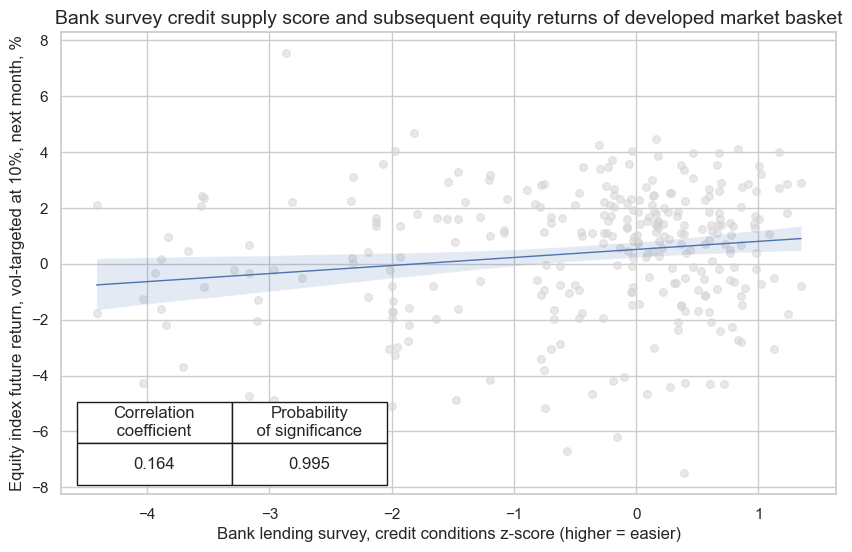

In [23]:
dix = dict_eqbk

dfr = dix["df"]
sig = dix["sigs"][1]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit conditions z-score (higher = easier)",
    ylab="Equity index future return, vol-targeted at 10%, next month, %",
    title="Bank survey credit supply score and subsequent equity returns of developed market basket",
    size=(10, 6),
)

### Accuracy and correlation check

The [`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [24]:
dix = dict_eqbk

dfr = dix["df"]
sigs = dix["sigs"]
targ = dix["targ"]
cidx = dix["cidx"]

srr = mss.SignalReturnRelations(
    dfr,
    cids=cidx,
    sigs=sigs,
    rets=targ,
    freqs="M",
    start="1995-01-01",
)

dix["srr"] = srr

dix = dict_eqbk
srrx = dix["srr"]


[`multiple_relations_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) is a method that compares multiple signal-return relations in one table. It is useful to compare the performance of different signals against the same return series (more than one possible financial return) and multiple possible frequencies. 

In [25]:
srrx.multiple_relations_table()

accuracy  bal_accuracy  \
Return    Signal        Frequency Aggregation                           
EQXR_VT10 BLSCSCORE_NSA M         last         0.551724      0.556387   
          BLSDSCORE_NSA M         last         0.555172      0.559048   

                                               pos_sigr  pos_retr  pos_prec  \
Return    Signal        Frequency Aggregation                                 
EQXR_VT10 BLSCSCORE_NSA M         last         0.479310  0.610345  0.669065   
          BLSDSCORE_NSA M         last         0.482759  0.610345  0.671429   

                                               neg_prec   pearson  \
Return    Signal        Frequency Aggregation                       
EQXR_VT10 BLSCSCORE_NSA M         last         0.443709  0.163962   
          BLSDSCORE_NSA M         last         0.446667  0.132989   

                                               pearson_pval   kendall  \
Return    Signal        Frequency Aggregation                           
EQXR_VT10 BLSCSCORE_NSA M         last             0.005125  0.082151   
          BLSDSCORE_NSA M         last             0.023512  0.075134   

                                               kendall_pval       auc  
Return    Signal        Frequency Aggregation                          
EQXR_VT10 BLSCSCORE_NSA M         last             0.037019  0.559172  
          BLSDSCORE_NSA M         last             0.056466  0.561997

### Naive PnL

As before, with fixed income returns, we create naive PnL using bank surveys as signals and equity returns as target. Please see [here](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) for details `NaivePnl()` class 

In [26]:
dix = dict_eqbk

dfr = dix["df"]
sigx = dix["sigs"]
targ = dix["targ"]
cidx = dix["cidx"]


naive_pnl = msn.NaivePnL(
    dfr,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    
)

dict_pnls = {
    "PZN0": {"sig_add": 0, "sig_op": "zn_score_pan"},
    "PZN1": {"sig_add": 1, "sig_op": "zn_score_pan"},
    "BIN0": {"sig_add": 0, "sig_op": "binary"},
    "BIN1": {"sig_add": 1, "sig_op": "binary"},
}

for key, value in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=False,
            sig_add=value["sig_add"],
            sig_op=value["sig_op"],
            thresh=3,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_" + key,
        )


naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the NaivePnl() class is used to plot a line chart of cumulative PnL

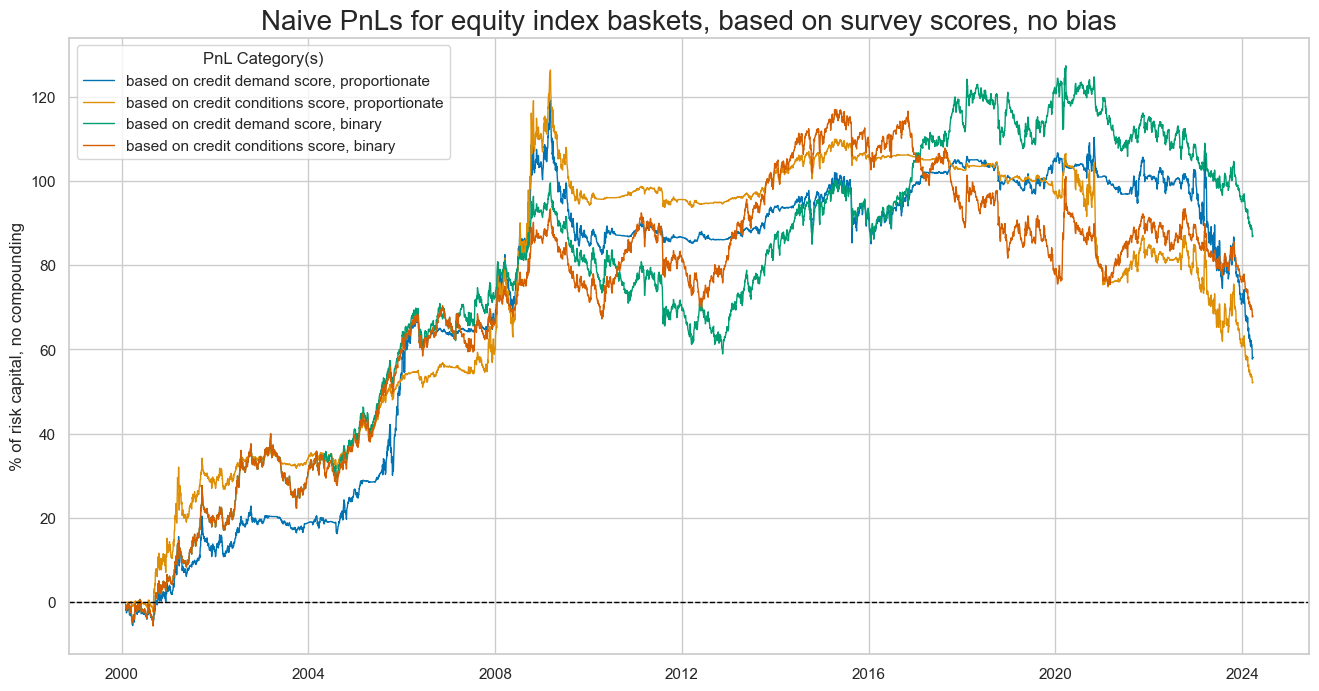

In [27]:
dix = dict_eqbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for type in ["_PZN0", "_BIN0"] for sig in sigx]

dict_labels = {"BLSDSCORE_NSA_PZN0": "based on credit demand score, proportionate", 
               "BLSCSCORE_NSA_PZN0": "based on credit conditions score, proportionate",
               "BLSDSCORE_NSA_BIN0": "based on credit demand score, binary", 
               "BLSCSCORE_NSA_BIN0": "based on credit conditions score, binary"
               }

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    title="Naive PnLs for equity index baskets, based on survey scores, no bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The below PnLs approximately add up returns of long-only and survey-based positions in equal weights to produce long-biased portfolios.

In [28]:
dix = dict_eqbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for type in ["_PZN0", "_BIN0"] for sig in sigx]
pnls

['BLSDSCORE_NSA_PZN0',
 'BLSCSCORE_NSA_PZN0',
 'BLSDSCORE_NSA_BIN0',
 'BLSCSCORE_NSA_BIN0']

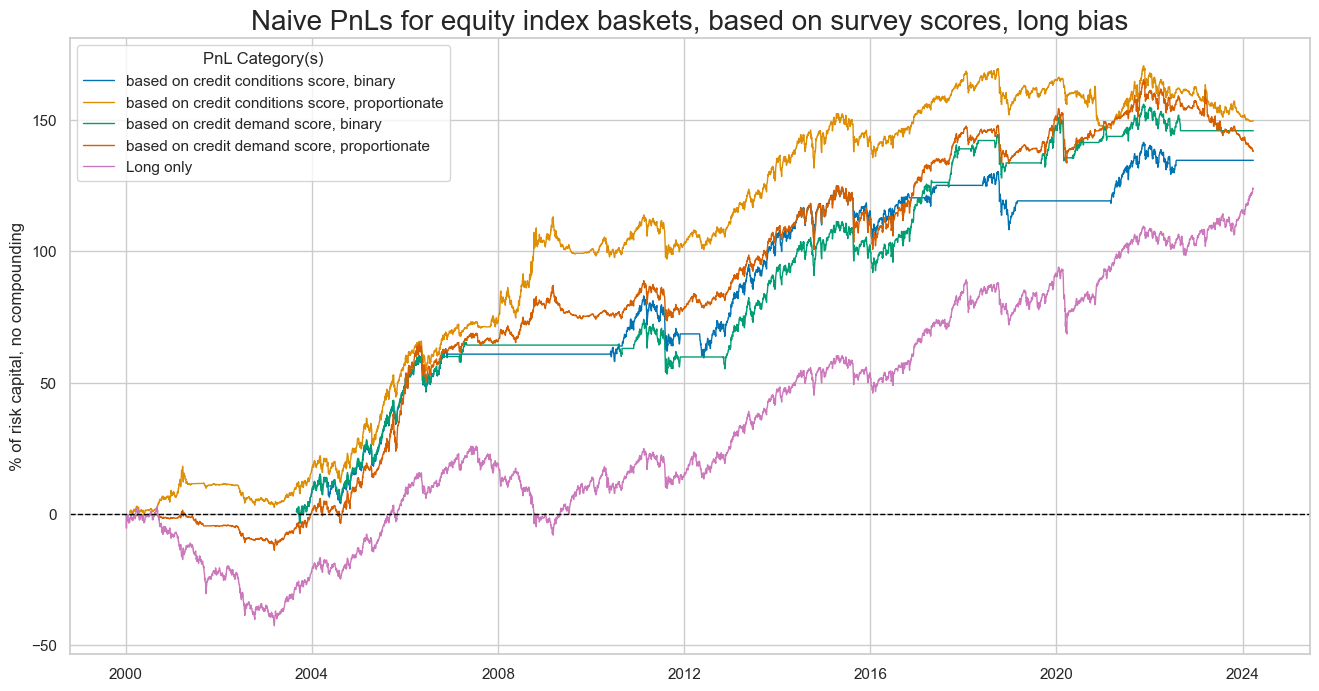

In [29]:
dix = dict_eqbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = sorted([sig + type for sig in sigx for type in ["_PZN1", "_BIN1"]]) + ["Long only"]


dict_labels = {"BLSDSCORE_NSA_PZN1": "based on credit demand score, proportionate", 
               "BLSCSCORE_NSA_PZN1": "based on credit conditions score, proportionate",
               "BLSDSCORE_NSA_BIN1": "based on credit demand score, binary", 
               "BLSCSCORE_NSA_BIN1": "based on credit conditions score, binary",
               "Long only": "Long only"
               }


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    title="Naive PnLs for equity index baskets, based on survey scores, long bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The method [evaluate_pnls()](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) returns a small dataframe of key PnL statistics.

In [30]:
dix = dict_eqbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for sig in sigx for type in ["_PZN0", "_PZN1", "_BIN0", "_BIN1"]] + [
    "Long only"
]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)


In [31]:
display(df_eval.transpose())

,Return (pct ar),St. Dev. (pct ar),Sharpe Ratio,Sortino Ratio,Max 21-day draw,Max 6-month draw,Traded Months
xcat,,,,,,,
BLSCSCORE_NSA_BIN0,2.814373,10.0,0.281437,0.40505,-12.065808,-16.593084,291
BLSCSCORE_NSA_BIN1,6.549787,10.0,0.654979,0.985328,-16.667449,-18.988845,291
BLSCSCORE_NSA_PZN0,2.163101,10.0,0.21631,0.316375,-22.624486,-28.500536,291
BLSCSCORE_NSA_PZN1,6.201297,10.0,0.62013,0.870014,-14.010911,-15.23333,291
BLSDSCORE_NSA_BIN0,3.603411,10.0,0.360341,0.517412,-12.066978,-15.953213,291
BLSDSCORE_NSA_BIN1,7.09783,10.0,0.709783,1.065741,-16.455291,-18.747138,291
BLSDSCORE_NSA_PZN0,2.405866,10.0,0.240587,0.347736,-20.839912,-29.168401,291
BLSDSCORE_NSA_PZN1,5.725593,10.0,0.572559,0.79515,-18.162164,-18.961423,291
Long only,5.114199,10.0,0.51142,0.699751,-23.703832,-21.00946,291


## Equity versus duration returns

In the final part of Value checks we look at the relation between bank survey scores and volatility-targeted equity versus duration returns for the developed market basket. The target will be the earlier created difference between equity and duration return, 10% volatility targeted (`EQvDUXR_VT10`)

### Specs and panel test

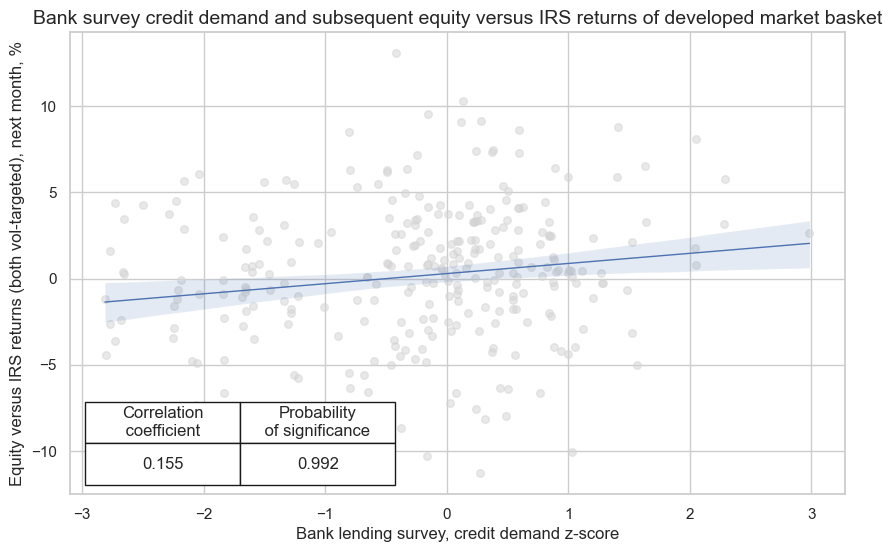

In [32]:
sigs = bls
targ = "EQvDUXR_VT10"
cidx = [
    "GDM",
]

dict_edbk = {
    "df": dfx,
    "sigs": sigs,
    "targ": targ,
    "cidx": cidx,
    "black": None,
    "srr": None,
    "pnls": None,
}

dix = dict_edbk

dfr = dix["df"]
sig = dix["sigs"][0]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit demand z-score",
    ylab="Equity versus IRS returns (both vol-targeted), next month, %",
    title="Bank survey credit demand and subsequent equity versus IRS returns of developed market basket",
    size=(10, 6),
)

Conducting a parallel analysis by employing the alternate bank survey metric, the credit supply score labeled as `BLSCSCORE_NSA`, and subsequently examining the "EQvDUXR_VT10" return:

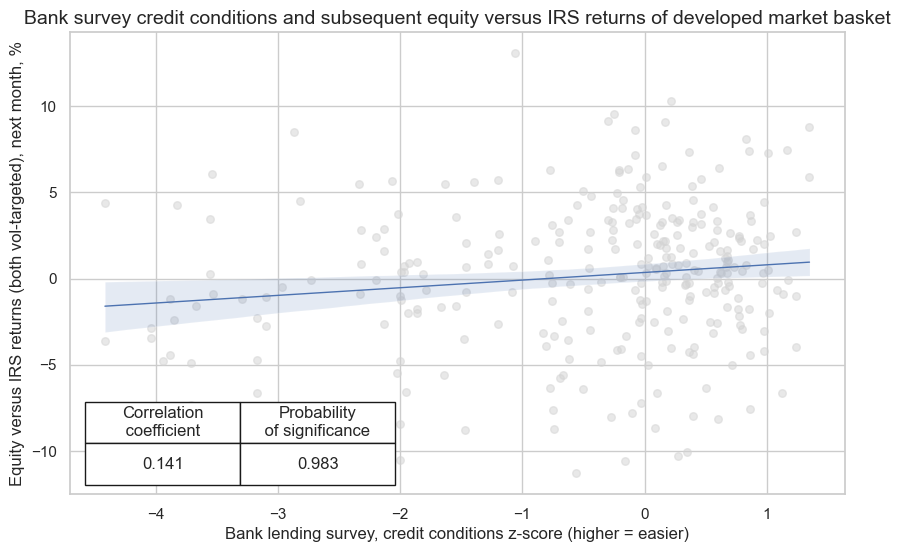

In [33]:
dix = dict_edbk

dfr = dix["df"]
sig = dix["sigs"][1]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Bank lending survey, credit conditions z-score (higher = easier)",
    ylab="Equity versus IRS returns (both vol-targeted), next month, %",
    title="Bank survey credit conditions and subsequent equity versus IRS returns of developed market basket",
    size=(10, 6),
)

### Accuracy and correlation check

The [`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [34]:
dix = dict_edbk

dfr = dix["df"]
sigs = dix["sigs"]
targ = dix["targ"]
cidx = dix["cidx"]

srr = mss.SignalReturnRelations(
    dfr,
    cids=cidx,
    sigs=sigs,
    rets=targ,
    freqs="M",
    start="1995-01-01",
)

dix["srr"] = srr

dix = dict_edbk
srrx = dix["srr"]


In [35]:
display(srrx.signals_table().sort_index().astype("float").round(3))

accuracy  bal_accuracy  \
Return       Signal        Frequency Aggregation                           
EQvDUXR_VT10 BLSCSCORE_NSA M         last            0.555         0.557   
             BLSDSCORE_NSA M         last            0.566         0.567   

                                                  pos_sigr  pos_retr  \
Return       Signal        Frequency Aggregation                       
EQvDUXR_VT10 BLSCSCORE_NSA M         last            0.479     0.545   
             BLSDSCORE_NSA M         last            0.483     0.545   

                                                  pos_prec  neg_prec  pearson  \
Return       Signal        Frequency Aggregation                                
EQvDUXR_VT10 BLSCSCORE_NSA M         last            0.604      0.51    0.141   
             BLSDSCORE_NSA M         last            0.614      0.52    0.155   

                                                  pearson_pval  kendall  \
Return       Signal        Frequency Aggregation                          
EQvDUXR_VT10 BLSCSCORE_NSA M         last                0.017    0.077   
             BLSDSCORE_NSA M         last                0.008    0.107   

                                                  kendall_pval    auc  
Return       Signal        Frequency Aggregation                       
EQvDUXR_VT10 BLSCSCORE_NSA M         last                0.051  0.557  
             BLSDSCORE_NSA M         last                0.007  0.568

### Naive PnL

As before, we create naive PnL using bank surveys as signals and equity returns as target. Please see [here](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) for details `NaivePnl()` class 

In [36]:
dix = dict_edbk

dfr = dix["df"]
sigx = dix["sigs"]
targ = dix["targ"]
cidx = dix["cidx"]


naive_pnl = msn.NaivePnL(
    dfr,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    
)

dict_pnls = {
    "PZN0": {"sig_add": 0, "sig_op": "zn_score_pan"},
    "PZN1": {"sig_add": 1, "sig_op": "zn_score_pan"},
    "BIN0": {"sig_add": 0, "sig_op": "binary"},
    "BIN1": {"sig_add": 1, "sig_op": "binary"},
}

for key, value in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=False,
            sig_add=value["sig_add"],
            sig_op=value["sig_op"],
            thresh=3,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_" + key,
        )


naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the NaivePnl() class is used to plot a line chart of cumulative PnL

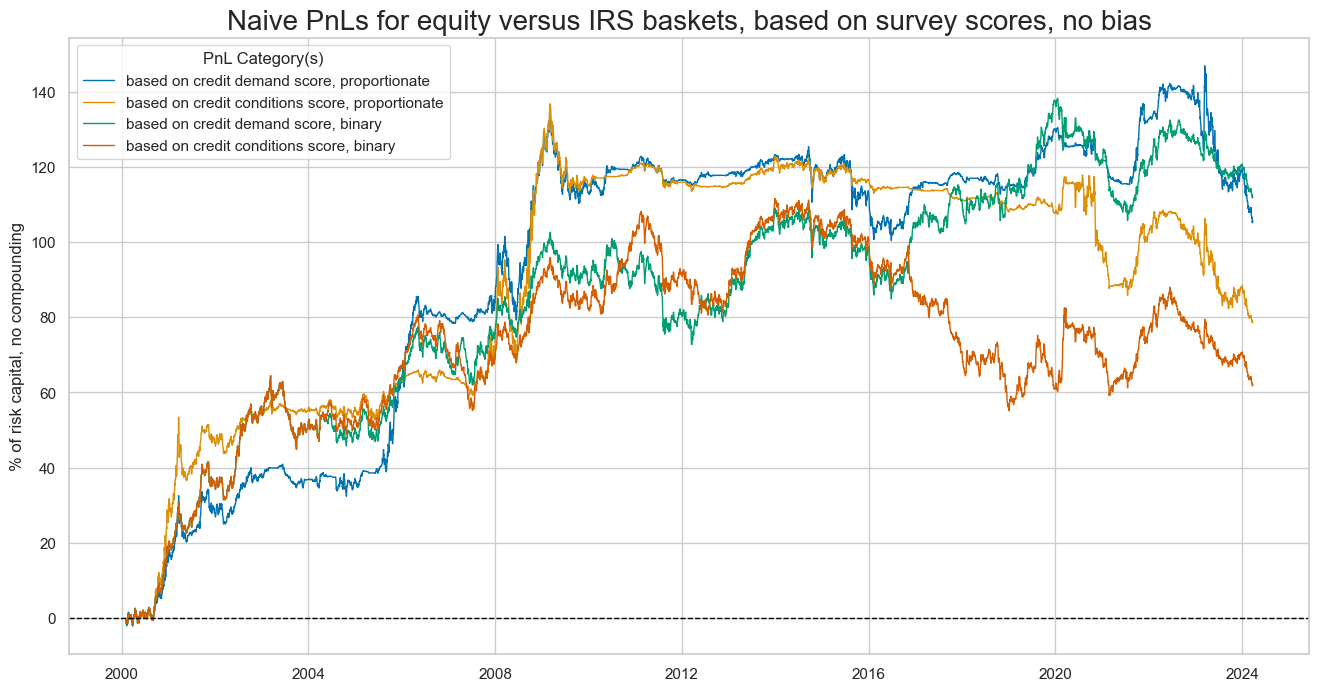

In [37]:
dix = dict_edbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for type in ["_PZN0", "_BIN0"] for sig in sigx]

dict_labels = {"BLSDSCORE_NSA_PZN0": "based on credit demand score, proportionate", 
               "BLSCSCORE_NSA_PZN0": "based on credit conditions score, proportionate",
               "BLSDSCORE_NSA_BIN0": "based on credit demand score, binary", 
               "BLSCSCORE_NSA_BIN0": "based on credit conditions score, binary",
               
               }

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    title="Naive PnLs for equity versus IRS baskets, based on survey scores, no bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

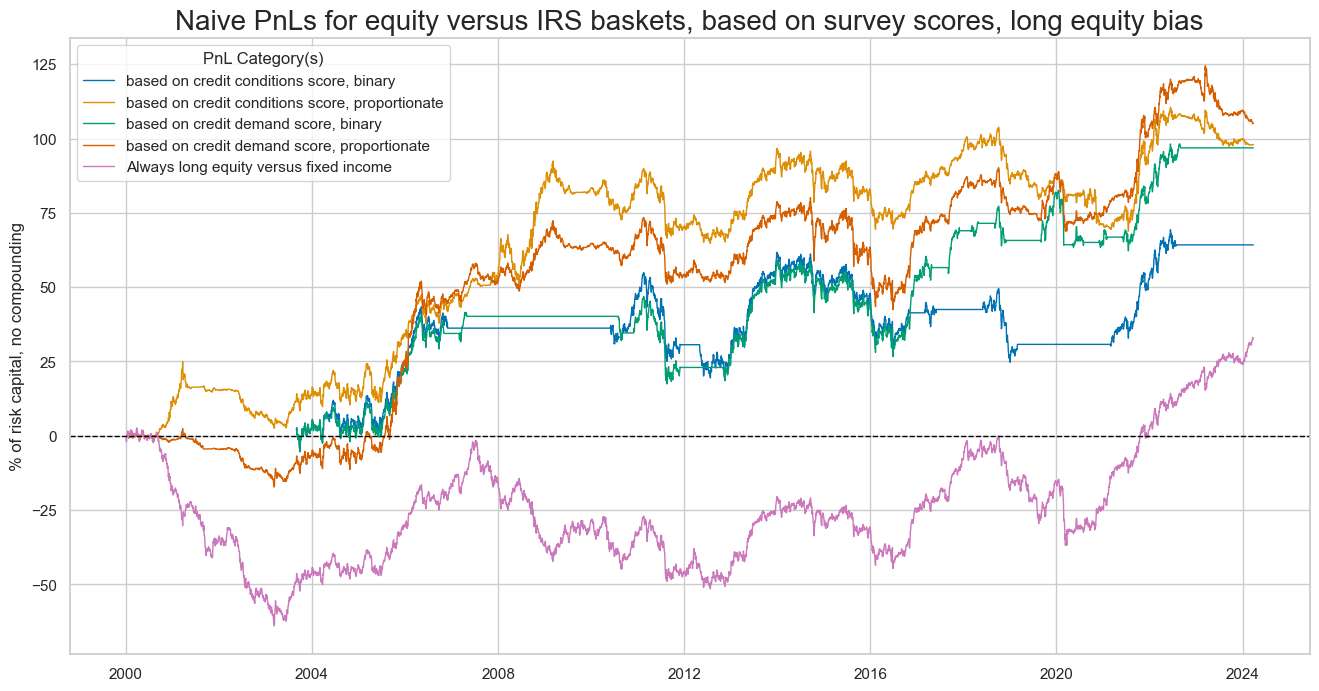

In [38]:
dix = dict_edbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = sorted([sig + type for sig in sigx for type in ["_PZN1", "_BIN1"]]) + ["Long only"]

dict_labels={"BLSDSCORE_NSA_PZN1": "based on credit demand score, proportionate", 
               "BLSCSCORE_NSA_PZN1": "based on credit conditions score, proportionate",
               "BLSDSCORE_NSA_BIN1": "based on credit demand score, binary", 
               "BLSCSCORE_NSA_BIN1": "based on credit conditions score, binary",
               "Long only": "Always long equity versus fixed income"
               
               }

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    title="Naive PnLs for equity versus IRS baskets, based on survey scores, long equity bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [39]:
dix = dict_edbk

sigx = dix["sigs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for sig in sigx for type in ["_PZN0", "_PZN1", "_BIN0", "_BIN1"]] + [
    "Long only"
]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)


In [40]:
display(df_eval.transpose())

,Return (pct ar),St. Dev. (pct ar),Sharpe Ratio,Sortino Ratio,Max 21-day draw,Max 6-month draw,Traded Months
xcat,,,,,,,
BLSCSCORE_NSA_BIN0,2.568152,10.0,0.256815,0.367062,-13.520579,-20.63655,291
BLSCSCORE_NSA_BIN1,3.124153,10.0,0.312415,0.469558,-18.432993,-28.134401,291
BLSCSCORE_NSA_PZN0,3.262396,10.0,0.32624,0.474418,-17.65661,-29.35528,291
BLSCSCORE_NSA_PZN1,4.058176,10.0,0.405818,0.568846,-15.795265,-21.980484,291
BLSDSCORE_NSA_BIN0,4.640368,10.0,0.464037,0.668771,-13.524447,-20.642454,291
BLSDSCORE_NSA_BIN1,4.712011,10.0,0.471201,0.714574,-18.165055,-27.725446,291
BLSDSCORE_NSA_PZN0,4.373259,10.0,0.437326,0.645153,-16.454033,-31.283752,291
BLSDSCORE_NSA_PZN1,4.354862,10.0,0.435486,0.61721,-19.550447,-25.152307,291
Long only,1.35191,10.0,0.135191,0.186025,-19.959885,-24.990098,291
